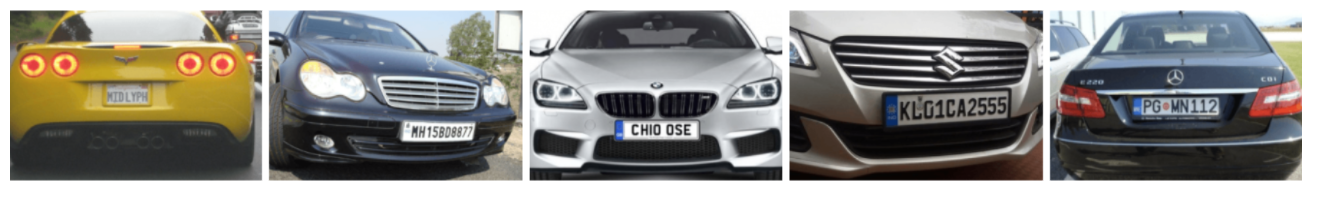

This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Preparation of the data

Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We create the variable X containing all the images of cars by resizing them.



In [2]:
IMAGE_SIZE = 224

In [3]:
img_dir = "../input/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [4]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [5]:
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [6]:
resizeannotation("/kaggle/input/car-plate-detection/annotations/Cars147.xml")

[188, 141, 101, 104]

In [7]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [8]:
np.array(X).shape

(433, 224, 224, 3)

In [9]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

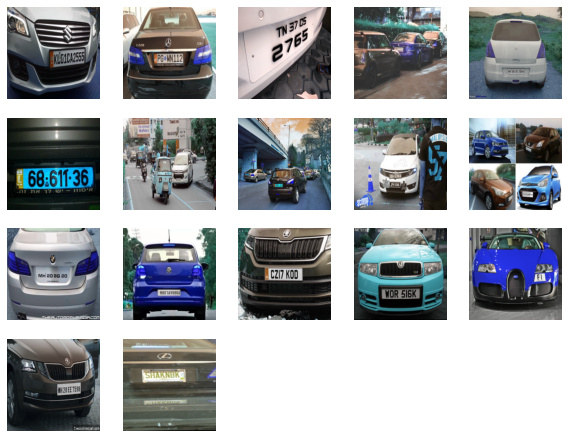

In [10]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

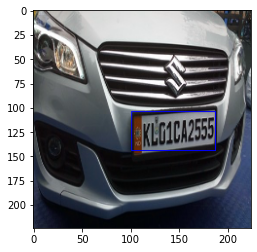

In [11]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


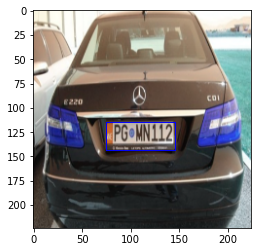

In [12]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [13]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [14]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [16]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense
model = Sequential()
model.add(Conv2D(64 , (3,3) , input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Conv2D(32 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='mean_squared_error',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0

In [17]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
11/11 [==============================] - 1s 73ms/step - loss: 0.1118 - accuracy: 0.5229 - val_loss: 0.0316 - val_accuracy: 0.4103
Epoch 2/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0249 - accuracy: 0.5257 - val_loss: 0.0273 - val_accuracy: 0.6154
Epoch 3/10
11/11 [==============================] - 0s 33ms/step - loss: 0.0197 - accuracy: 0.5914 - val_loss: 0.0259 - val_accuracy: 0.6154
Epoch 4/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0134 - accuracy: 0.6829 - val_loss: 0.0222 - val_accuracy: 0.6667
Epoch 5/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0084 - accuracy: 0.8114 - val_loss: 0.0224 - val_accuracy: 0.7692
Epoch 6/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0051 - accuracy: 0.8371 - val_loss: 0.0208 - val_accuracy: 0.8205
Epoch 7/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0035 - accuracy: 0.9086 - val_loss: 0.0185 - val_accuracy: 0.7179
Epoch 8/10
11

In [18]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 63.64%


In [19]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

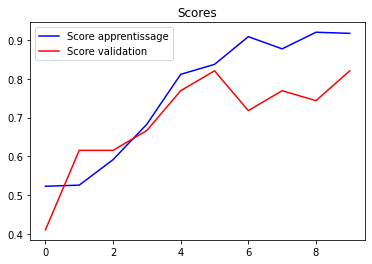

In [20]:
plot_scores(train)

## DETECTION 

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


 44/100 [============>.................] - 0s 3ms/step - loss: 0.0134 - accuracy: 0.6364
Test results 
 Loss: 0.013401458039879799 
 Accuracy 0.6363636255264282


In [22]:
 y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

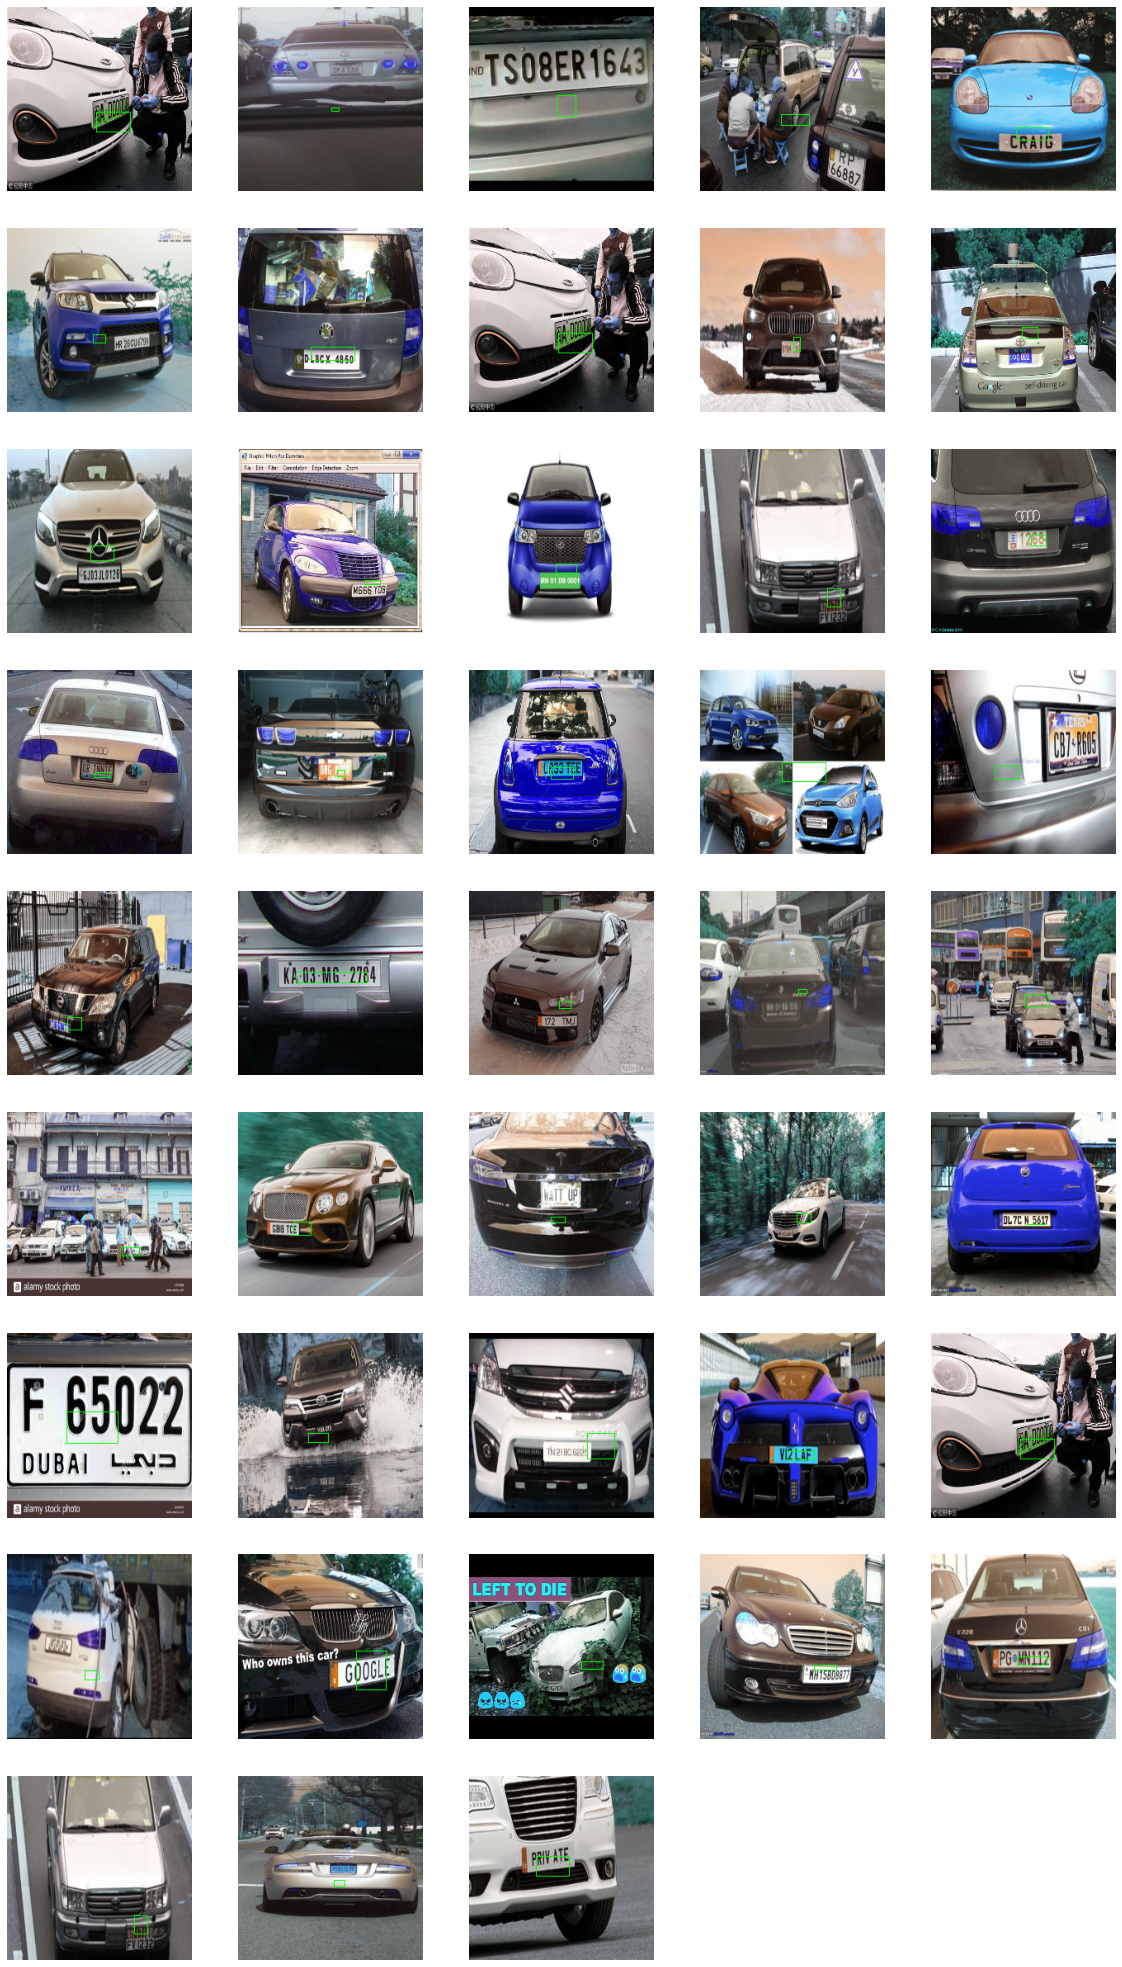

In [23]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

